# Navigation via DQN

---

## Training of a DQN agent playing "Banana" environment

### Initializing environment

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import tensorflow as tf
import importlib
import sys
import matplotlib.pyplot as plt
import tqdm
from collections import namedtuple, deque
import random
import seaborn as sns

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Creating agent

In [2]:
from dqn_agent import Agent
from model import QNetworkTf

In [3]:
class ReinforcementNetwork(QNetworkTf):
    def _inference(self):
        with tf.variable_scope("inference_"+self.name):
            layer = tf.layers.dense(self.input, 128, activation=tf.nn.relu)
            layer = tf.layers.dense(layer, 128, activation=tf.nn.relu)
            output = tf.layers.dense(layer, 4)
        return output

In [4]:
env = UnityEnvironment(file_name = "data/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [5]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0 
reward = None
done = False

In [6]:
dqn_agent = Agent(ReinforcementNetwork, 37, 4, 42)

In [7]:
def run(agent, env, num_episodes=20000, mode='train'):
    """Run agent in given reinforcement learning environment and return scores."""
    scores = []
    max_avg_score = -np.inf
    train_mode=True
    agent.set_epsilon(1.0, 0.01, 0.5*num_episodes)

    if mode=='test':
        num_episodes = 1
        train_mode=False
        
    with tqdm.trange(1, num_episodes+1) as t:
        for i_episode in t:
            last_state = None
            last_action = None
            state = env.reset(train_mode=train_mode)[brain_name].vector_observations[0] 

            total_reward = 0
            done = False
            action = agent.act(state)
            
            while not done:
                env_info = env.step([action])[brain_name]
                state = env_info.vector_observations[0]   
                reward = env_info.rewards[0]
                done = env_info.local_done[0]

                total_reward += reward
                
                if last_state is not None:
                    agent.step(last_state, last_action, reward, state, done)
                action = agent.act(state, mode)
                
                last_state = state
                last_action = action
                
            scores.append(total_reward)
            agent.reset_episode()
            
            if mode == 'train':
                if i_episode>100:
                    mn = np.mean(scores[-100:])
                else:
                    mn = 0
                t.set_postfix(max_score=np.max(scores), loss=agent.loss, mean_score=mn)
                agent.loss = 0
                agent.learning_steps = 0
                if mn>13.0:
                    print(f"Achieved mean 13.0 in {i_episode} episodes")
                    break
    return scores

scores = run(dqn_agent, env, num_episodes=2000, mode='train')

 23%|████████▏                          | 467/2000 [08:17<27:12,  1.06s/it, loss=0.0212, max_score=24, mean_score=13.1]

Achieved mean 13.0 in 468 episodes


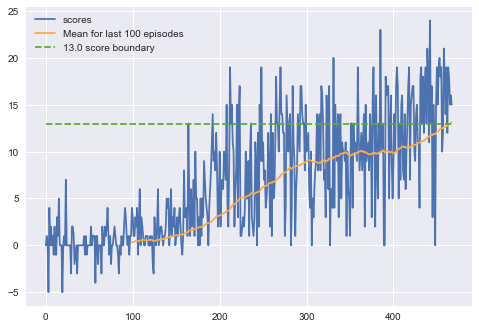

In [34]:
means = np.convolve(scores, np.ones((100,))/100, mode='valid')
plt.style.use('seaborn')
plt.plot(scores, label='scores')
plt.plot(np.arange(len(scores)-len(means), len(scores)), means, color='xkcd:light orange', label='Mean for last 100 episodes')
plt.plot(np.arange(len(scores)), 13*np.ones(len(scores)), '--', color='xkcd:grass', label='13.0 score boundary')
plt.legend()
plt.show()
# run(dqn_agent, env, num_episodes=1, mode='test')

In [10]:
run(dqn_agent, env, num_episodes=1, mode='test')

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:30<00:00, 30.05s/it]


[14.0]

In [9]:
dqn_agent.saver.save(dqn_agent.sess, "models/model.ckpt") 

'models/model.ckpt'